In [23]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from scipy.spatial.distance import euclidean

# Load dataset
file_path = "../merged_nfl.csv"
df = pd.read_csv(file_path)

# Select relevant columns
df = df[['Player_df2_x', 'Pos', 'Pageviews', 'PaYds', 'PaTD', 'RecYds', 'RecTD', 'RuYds', 'RuTD', 'Solo', 'Ast', 'Sfty']]

# Rename for clarity
df.rename(columns={'Player_df2_x': 'Player'}, inplace=True)

# Fill missing values with 0
df.fillna(0, inplace=True)

# Display first rows
df.head()


,Player,Pos,Pageviews,PaYds,PaTD,RecYds,RecTD,RuYds,RuTD,Solo,Ast,Sfty
0,Kyler Murray,QB,845475.0,19498,115,7,0,3020,31,0,0,0
1,Clayton Tune,QB,56850.0,70,0,0,0,26,1,0,0,0
2,Trey Benson,RB,110208.0,0,0,59,0,291,1,0,0,0
3,Michael Carter,RB,50197.0,0,0,771,1,1359,8,1,0,0
4,James Conner,RB,198361.0,0,0,2217,11,5970,59,2,0,0


In [24]:

# Features for clustering
features = ['PaYds', 'PaTD', 'RecYds', 'RecTD', 'RuYds', 'RuTD', 'Solo', 'Ast', 'Sfty', 'Pageviews']

# Standardize features
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[features] = scaler.fit_transform(df[features])

df_scaled.head()


,Player,Pos,Pageviews,PaYds,PaTD,RecYds,RecTD,RuYds,RuTD,Solo,Ast,Sfty
0,Kyler Murray,QB,1.871520,5.335265,4.663330,-0.262428,-0.255799,4.140510,5.068836,-0.479047,-0.482062,-0.129008
1,Clayton Tune,QB,-0.171126,-0.108825,-0.121126,-0.268481,-0.255799,-0.166588,-0.023797,-0.479047,-0.482062,-0.129008
2,Trey Benson,RB,-0.032921,-0.128440,-0.121126,-0.217460,-0.255799,0.214634,-0.023797,-0.479047,-0.482062,-0.129008
3,Michael Carter,RB,-0.188358,-0.128440,-0.121126,0.398251,-0.126810,1.751034,1.164484,-0.469718,-0.482062,-0.129008
4,James Conner,RB,0.195407,-0.128440,-0.121126,1.648699,1.163084,8.384311,9.821959,-0.460390,-0.482062,-0.129008


In [25]:

# Perform KMeans clustering within each position
k = 3  # Number of clusters per position
cluster_assignments = []
centroids = []

for pos, group in df_scaled.groupby("Pos"):
    if len(group) < k:
        continue

    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(group[features])

    # Assign clusters
    labels = kmeans.labels_
    for idx, label in zip(group.index, labels):
        cluster_assignments.append({'Index': idx, 'Cluster': label, 'Pos': pos})

    # Store cluster centroids
    # Compute average Pageviews per cluster so we can store it
    group['Cluster'] = kmeans.labels_
    cluster_pageviews = group.groupby('Cluster')['Pageviews'].mean().to_dict()

    for i, centroid in enumerate(kmeans.cluster_centers_):
        centroids.append({
            'Pos': pos, 'Cluster': i, 'Avg_Pageviews': cluster_pageviews.get(i, 0),
            **{f: v for f, v in zip(features, centroid)}
        })


# Convert results to DataFrame
cluster_df = pd.DataFrame(cluster_assignments).set_index("Index")
df_scaled['Cluster'] = cluster_df['Cluster']

centroids_df = pd.DataFrame(centroids)
df_scaled.head()


,Player,Pos,Pageviews,PaYds,PaTD,RecYds,RecTD,RuYds,RuTD,Solo,Ast,Sfty,Cluster
0,Kyler Murray,QB,1.871520,5.335265,4.663330,-0.262428,-0.255799,4.140510,5.068836,-0.479047,-0.482062,-0.129008,0.0
1,Clayton Tune,QB,-0.171126,-0.108825,-0.121126,-0.268481,-0.255799,-0.166588,-0.023797,-0.479047,-0.482062,-0.129008,1.0
2,Trey Benson,RB,-0.032921,-0.128440,-0.121126,-0.217460,-0.255799,0.214634,-0.023797,-0.479047,-0.482062,-0.129008,0.0
3,Michael Carter,RB,-0.188358,-0.128440,-0.121126,0.398251,-0.126810,1.751034,1.164484,-0.469718,-0.482062,-0.129008,0.0
4,James Conner,RB,0.195407,-0.128440,-0.121126,1.648699,1.163084,8.384311,9.821959,-0.460390,-0.482062,-0.129008,1.0


In [26]:

cluster_popularity = centroids_df[['Pos', 'Cluster', 'Avg_Pageviews']]
most_popular_clusters = cluster_popularity.loc[cluster_popularity.groupby('Pos')['Avg_Pageviews'].idxmax()]

# Merge with centroid data to get the most popular cluster centroids per position
popular_centroids = most_popular_clusters.merge(centroids_df, on=['Pos', 'Cluster'])

# Create mapping of most popular centroids per position
pos_to_centroid = {row['Pos']: row[features].values for _, row in popular_centroids.iterrows()}

df_scaled.head()


,Player,Pos,Pageviews,PaYds,PaTD,RecYds,RecTD,RuYds,RuTD,Solo,Ast,Sfty,Cluster
0,Kyler Murray,QB,1.871520,5.335265,4.663330,-0.262428,-0.255799,4.140510,5.068836,-0.479047,-0.482062,-0.129008,0.0
1,Clayton Tune,QB,-0.171126,-0.108825,-0.121126,-0.268481,-0.255799,-0.166588,-0.023797,-0.479047,-0.482062,-0.129008,1.0
2,Trey Benson,RB,-0.032921,-0.128440,-0.121126,-0.217460,-0.255799,0.214634,-0.023797,-0.479047,-0.482062,-0.129008,0.0
3,Michael Carter,RB,-0.188358,-0.128440,-0.121126,0.398251,-0.126810,1.751034,1.164484,-0.469718,-0.482062,-0.129008,0.0
4,James Conner,RB,0.195407,-0.128440,-0.121126,1.648699,1.163084,8.384311,9.821959,-0.460390,-0.482062,-0.129008,1.0


In [27]:

# # Compute Euclidean distance from each player's position-based most popular cluster
# def compute_obscurity(row):
#     pos = row['Pos']
#     if pos in pos_to_centroid:
#         return euclidean(row[features], pos_to_centroid[pos])
#     return None

# df_scaled['Obscurity'] = df_scaled.apply(compute_obscurity, axis=1)

from scipy.spatial.distance import euclidean

# Define custom weighting for pageviews
feature_weights = {
    "Pageviews": 5,  # Increase influence of popularity
    "PaYds": 1, "PaTD": 1, "RecYds": 1, "RecTD": 1,
    "RuYds": 1, "RuTD": 1, "Solo": 1, "Ast": 1, "Sfty": 1
}

# Weighted Euclidean distance
def weighted_euclidean(player_stats, centroid):
    weighted_stats = [feature_weights.get(col, 1) * player_stats[col] for col in features]
    weighted_centroid = [feature_weights.get(col, 1) * centroid[col] for col in features]
    return euclidean(weighted_stats, weighted_centroid)

# Compute obscurity with new distance function
df_scaled['Obscurity'] = df_scaled.apply(
    lambda row: weighted_euclidean(row, pd.Series(pos_to_centroid[row['Pos']], index=features)) 
    if row['Pos'] in pos_to_centroid else None, 
    axis=1
)

# Normalize obscurity score
scaler = MinMaxScaler()
df_scaled['ObscurityScore'] = scaler.fit_transform(df_scaled[['Obscurity']])

# Sort by highest obscurity
df_sorted = df_scaled.sort_values(by='ObscurityScore', ascending=False)
df_sorted[['Player', 'Pos', 'Pageviews', 'ObscurityScore']].head(10)


,Player,Pos,Pageviews,ObscurityScore
422,Cam Grandy,TE,-0.310532,1.000000
2059,David Martin-Robinson,TE,-0.308797,0.999939
477,Troy Hairston,TE,-0.301241,0.999592
17,Travis Vokolek,TE,-0.297859,0.999454
92,Nikola Kalinic,TE,-0.297395,0.999434
856,Brandon Hill,TE,-0.296859,0.999405
2140,Colson Yankoff,TE,-0.295232,0.999337
1294,Tanner Conner,TE,-0.293984,0.999269
1715,E. J. Jenkins,TE,-0.294090,0.999177
385,Stephen Carlson,TE,-0.290844,0.998992


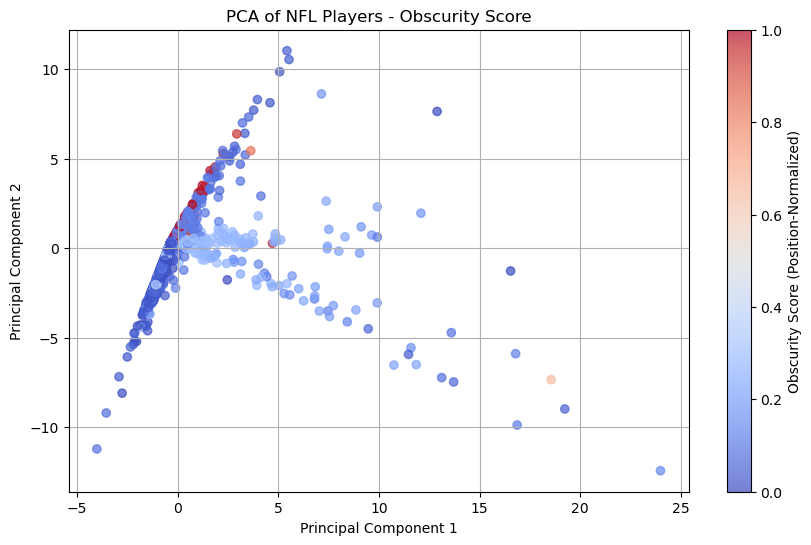

In [28]:

# Reduce dimensions with PCA
pca = PCA(n_components=2)
pca_proj = pca.fit_transform(df_scaled[features])

# Plot with obscurity coloring
plt.figure(figsize=(10,6))
scatter = plt.scatter(pca_proj[:,0], pca_proj[:,1], c=df_scaled['ObscurityScore'], cmap='coolwarm', alpha=0.7)
plt.colorbar(label="Obscurity Score (Position-Normalized)")
plt.title("PCA of NFL Players - Obscurity Score")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()


In [29]:
df_sorted[['Player', 'Pos', 'Pageviews', 'ObscurityScore']].tail(25)

,Player,Pos,Pageviews,ObscurityScore
179,Roquan Smith,RILB,0.392933,2.501765e-19
459,Trent Brown,RT,0.024709,1.250882e-19
151,Derrick Henry,RB,4.678681,1.250882e-19
1572,Jon Runyan Jr.,RG,0.016675,1.250882e-19
1383,Andrew Van Ginkel,LOLB,0.318739,0.000000e+00
132,Matthew Judon,ROLB,0.320272,0.000000e+00
1064,Harrison Butker,K,3.630930,0.000000e+00
588,Micah Parsons,LLB,1.139568,0.000000e+00
462,Cody Ford,G,0.228685,0.000000e+00
916,DeForest Buckner,RDT,0.069221,0.000000e+00


In [30]:
df_sorted[df_sorted["Pos"] == "QB"]

,Player,Pos,Pageviews,PaYds,PaTD,RecYds,RecTD,RuYds,RuTD,Solo,Ast,Sfty,Cluster,Obscurity,ObscurityScore
1016,Patrick Mahomes,QB,20.709818,8.937197,10.071846,-0.261563,-0.255799,3.022736,2.183011,-0.460390,-0.464459,-0.129008,2.0,72.693254,0.655225
1,Clayton Tune,QB,-0.171126,-0.108825,-0.121126,-0.268481,-0.255799,-0.166588,-0.023797,-0.479047,-0.482062,-0.129008,1.0,36.305083,0.327238
958,John Wolford,QB,-0.176588,0.046977,-0.079522,-0.268481,-0.255799,-0.078835,-0.193551,-0.479047,-0.482062,-0.129008,1.0,36.276541,0.326981
156,Malik Cunningham,QB,-0.135659,-0.128440,-0.121126,-0.268481,-0.255799,-0.203991,-0.193551,-0.479047,-0.482062,-0.129008,1.0,36.178200,0.326094
1215,Easton Stick,QB,-0.104044,0.189048,0.003685,-0.268481,-0.255799,0.000286,-0.023797,-0.479047,-0.482062,-0.129008,1.0,35.860063,0.323227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
942,Joe Flacco,QB,4.441337,12.676716,10.571094,-0.240809,-0.255799,1.076342,2.522520,-0.469718,-0.482062,-0.129008,2.0,9.173598,0.082687
1977,Baker Mayfield,QB,5.806880,6.829952,6.993152,-0.253780,-0.255799,1.523739,1.503993,-0.469718,-0.482062,-0.129008,0.0,7.626935,0.068746
77,Kirk Cousins,QB,4.743520,11.915082,11.860817,-0.269346,-0.255799,1.174165,3.031783,-0.469718,-0.464459,-0.129008,2.0,7.484283,0.067460
1831,Russell Wilson,QB,6.048345,12.799452,14.440263,-0.250321,-0.126810,7.653514,5.068836,-0.479047,-0.482062,-0.129008,2.0,5.720916,0.051566
